# AAI Mini Project - Self-driving Jet Racer

## project setup

In [84]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib as mpl
import random
import PIL
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

dataset_dir = 'Dataset'
dataset_dir = os.path.join(os.getcwd(), dataset_dir)
print(dataset_dir)

/Users/lucavanstraaten/Documents/hhs/minor/Applied Artificial Intelligence/lab/project/Dataset


## Collecting images

please see a few random images from the dataset with the labels

the images are stored in the folder `Dataset` and the labels are the filename of the images

In [85]:
# Load the dataset, the folder contains all the images and the filename is the labels comma separated: "steering angle, throttle, image number.png"
# ignore all non png files

# create a list of all the files in the dataset folder
Dataset = []

for file in os.listdir(dataset_dir):
    if file.endswith(".png"):
        # add the file to the list
        Dataset.append(file)

# create a dataframe with the dataset
df = pd.DataFrame(Dataset, columns=['filename'])

# split the filename into 3 columns: steering angle, throttle, image number. but also keep the original filename
df[['steering_angle', 'throttle', 'image_number']] = df.filename.str.split(",",expand=True,)
df['image_number'] = df['image_number'].str.replace('.png', '')

# convert the columns to float
df['steering_angle'] = df['steering_angle'].astype(float)
df['throttle'] = df['throttle'].astype(float)

# convert image number to int
df['image_number'] = df['image_number'].astype(int)

# remove the filename column
# df = df.drop(['filename'], axis=1)

# sort the dataframe by image number
df = df.sort_values(by=['image_number'])

# reset the index
df = df.reset_index(drop=True)

# print the first 5 rows
df.head()


/var/folders/gd/_tzcwhnj41j_nysfjnpl80sc0000gn/T/ipykernel_49839/4250320461.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df['image_number'] = df['image_number'].str.replace('.png', '')


,filename,steering_angle,throttle,image_number
0,"0.64,0.0,0.png",0.64,0.00,0
1,"0.1,-0.72,1.png",0.10,-0.72,1
2,"-0.02,-0.41,2.png",-0.02,-0.41,2
3,"0.24,-0.24,3.png",0.24,-0.24,3
4,"0.52,-0.63,4.png",0.52,-0.63,4


In [86]:
def preprocess(image):
    assert image.shape == (224,224,3)
    # crop the top 50 pixels
    image = image[70:,:,:]
    # convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # resize to 64x64
    image = cv2.resize(image, (64, 64))
    
    return image

In [87]:
# now save the images in a np.array data and the labels in a np.array data_labels
# data_labels = [steering_angle, throttle]
data = []
data_labels = []

for _, row in df.iterrows():
    # read the image and put it through the preprocessing function
    image = preprocess(cv2.imread(os.path.join(dataset_dir, row['filename'])))
    # add the image to the data array
    data.append(image)
    # add the labels to the data_labels array
    data_labels.append([row['steering_angle'], row['throttle']])

# convert the data and data_labels to np.array
data = np.array(data)
data_labels = np.array(data_labels)

# print the shape of the data and data_labels
print(data.shape)
print(data_labels.shape)

(492, 64, 64)
(492, 2)


In [88]:
# we note that we can easily create more data by flipping the images and changing the steering angle sign

# create a new array with the flipped images
data_flipped = np.flip(data, axis=2)

# create a new array with the flipped labels
data_labels_flipped = np.copy(data_labels)
data_labels_flipped[:,0] = -data_labels_flipped[:,0]

# now we can add the flipped images to the data and data_labels
data = np.concatenate((data, data_flipped), axis=0)
data_labels = np.concatenate((data_labels, data_labels_flipped), axis=0)

# print the shape of the data and data_labels
print(data.shape)
print(data_labels.shape)

(984, 64, 64)
(984, 2)


In [89]:
# we flip the sign of the steering angle and the throttle so that left is negative and right is positive, and the throttle is negative when braking and positive when accelerating
data_labels[:,0] = -data_labels[:,0]
data_labels[:,1] = -data_labels[:,1]

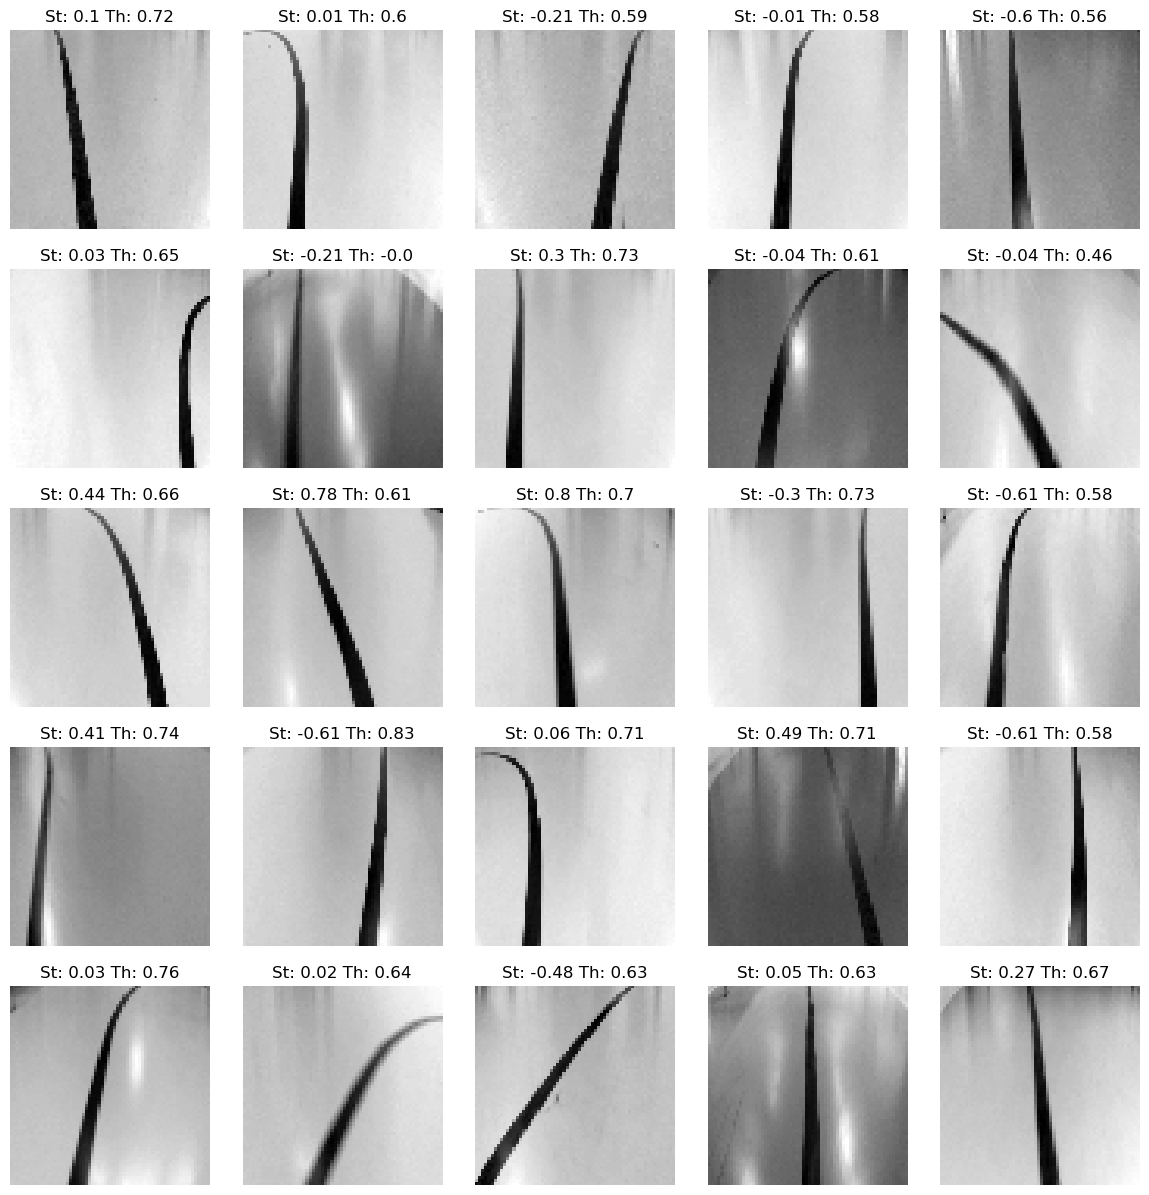

In [90]:
# plot 25 random images and their labels
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(25):
    index = random.randint(0, data.shape[0])
    axs[i].imshow(data[index], cmap='gray')
    axs[i].set_title("St: " + str(data_labels[index][0]) + " Th: " + str(data_labels[index][1]))
    axs[i].axis('off')

## checkin the dataset

we have a little less than 1000 images in the dataset and we want to know the distribution of the labels

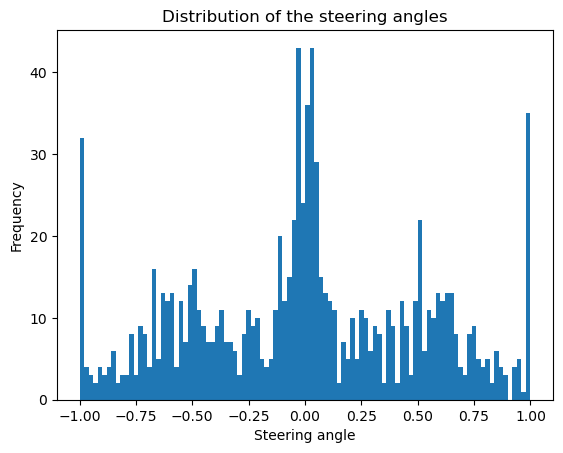

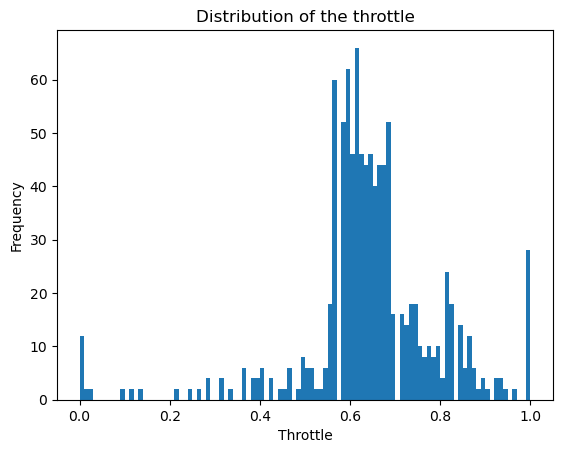

In [91]:
# plot the distribution of the steering angles
plt.hist(data_labels[:,0], bins=100)
plt.title("Distribution of the steering angles")
plt.xlabel("Steering angle")
plt.ylabel("Frequency")
plt.show()

# plot the distribution of the throttle
plt.hist(data_labels[:,1], bins=100)
plt.title("Distribution of the throttle")
plt.xlabel("Throttle")
plt.ylabel("Frequency")
plt.show()

# Splitting the dataset

We want to split the dataset into test and train dataset
We will use 80% of the dataset for training and 20% for testing

We then split the train into training and validation dataset

In [92]:
# split the data into test and train and validation
X_train, X_test, y_train, y_test = train_test_split(data, data_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# print the shape of the data and data_labels
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(629, 64, 64)
(629, 2)
(158, 64, 64)
(158, 2)
(197, 64, 64)
(197, 2)


## Training the model

we will use a simple CNN model to train the dataset